<a href="https://colab.research.google.com/github/DmitryKutsev/DeepHW/blob/master/my_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-10-13 21:35:51--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  29.6MB/s    in 23s     

2020-10-13 21:36:14 (28.8 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [3]:
!wget https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py

--2020-10-13 21:36:14--  https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10563 (10K) [text/plain]
Saving to: ‘data.py’

data.py             100%[===================>]  10.32K  --.-KB/s    in 0s      

2020-10-13 21:36:14 (95.0 MB/s) - ‘data.py’ saved [10563/10563]



In [4]:
!mv data.py mydata.py

In [5]:
import math
import numpy as np
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
import zipfile
from torch import nn
import seaborn as sns
from mydata import Downloader, Parser
import matplotlib.pyplot as plt

In [6]:
torch.__version__

'1.6.0+cu101'

### **DATA**


In [7]:
data_path = './my_data/'

In [8]:
downloader = Downloader(data_path=data_path)

In [9]:
downloader.run()

multiple: 100%|██████████| 17/17 [01:04<00:00,  3.77s/it]


In [10]:
parser = Parser(data_path=data_path)

In [11]:

unlabeled, train, valid = parser.run()

Reading: 100%|██████████| 38/38 [02:32<00:00,  4.01s/it]


In [12]:
s = 'ривет привет как дела? ха, дерьмо.'
wordpunct_tokenize(s)

['ривет', 'привет', 'как', 'дела', '?', 'ха', ',', 'дерьмо', '.']

In [13]:
unique_categories = set(train.category.unique().tolist() + valid.category.unique().tolist())

category2index = {category: index for index, category in enumerate(unique_categories)}

In [14]:
train['target'] = train.category.map(category2index)
valid['target'] = valid.category.map(category2index)

In [15]:
valid['target'][:3]

0    0
1    6
2    4
Name: target, dtype: int64

In [16]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab, pad_index=0, max_length=32):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        
        self.pad_index = pad_index
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def tokenization(self, text):
        
        tokens = wordpunct_tokenize(text)
        
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        
        return token_indices
    
    def padding(self, tokenized_text):
        
        tokenized_text = tokenized_text[:self.max_length]
        
        tokenized_text += [self.pad_index] * (self.max_length - len(tokenized_text))
        
        return tokenized_text
    
    def __getitem__(self, index):
        
        text = self.texts[index]        
        target = self.targets[index]
        
        tokenized_text = self.tokenization(text)
        tokenized_text = self.padding(tokenized_text)
        
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target

In [17]:
train_x = list(train.question)
train_y = list(train.target)

valid_x = list(valid.question)
valid_y = list(valid.target)

### **Embeddings**

In [18]:
def load_embeddings(zip_path, filename, pad_token='PAD', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
            max_words = vocab_size if max_words <= 0 else max_words
            
            # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [19]:
vocab, embeddings = load_embeddings('./wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec', max_words=100_000)

100%|█████████▉| 99999/100000 [00:11<00:00, 8356.97it/s]


In [20]:
index2token = {index: token for token, index in vocab.items()}

In [21]:
emb_norms = np.linalg.norm(embeddings, axis=1)

In [22]:
#print(len(train_loader))

In [23]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
x, y = train_dataset[0]

In [24]:
embeddings = torch.tensor(embeddings).float()
embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
x_embed = embedding_layer(x)

In [25]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
valid_dataset = TextClassificationDataset(texts=valid_x, targets=valid_y, vocab=vocab)

train_loader = DataLoader(train_dataset, batch_size=128)
valid_loader = DataLoader(valid_dataset, batch_size=128)

### **AVERAGE MODEL**

In [26]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, embeddings, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
        
        self.linear_1 = nn.Linear(in_features=embeddings.shape[-1], out_features=linear_1_size)
        self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
        self.linear_3 = nn.Linear(in_features=linear_2_size, out_features=n_classes)
        
    def forward(self, x):
        
        # переводим индексы слов в эмбеддинги этих слов
        # (batch_size, sequence_length) -> (batch_size, sequence_length, embedding_dim)
        x = self.embedding_layer(x)
        
        # агрегируем наши эмбеддинги по размерности время
        # (batch_size, sequence_length, embedding_dim) -> (batch_size, embedding_dim)
        x = x.sum(dim=1)
        
        # делаем нормирование
        # (batch_size, embedding_dim) -> (batch_size, embedding_dim)
        x = self.batch_norm(x)
        
        # прогоняем через первый линейный слой
        # (batch_size, embedding_dim) -> (batch_size, linear_1_size)
        x = self.linear_1(x)
        
        # применяем нелинейность
        # (batch_size, linear_1_size) -> (batch_size, linear_1_size)
        x = torch.relu(x)
        
        # прогоняем через второй линейный слой
        # (batch_size, linear_1_size) -> (batch_size, linear_2_size)
        x = self.linear_2(x)
        
        # применяем нелинейность
        # (batch_size, linear_2_size) -> (batch_size, linear_2_size)
        x = torch.relu(x)
        
        # переводим с помощью линейного преобразования в количество классов
        # (batch_size, linear_2_size) -> (batch_size, n_classes)
        x = self.linear_3(x)
        
        ## по идеи здесь должен был быть софтмакс
        ## но мы будем использовать лосс nn.CrossEntropyLoss()
        ## в его документации написано
        ## This criterion combines :func:`nn.LogSoftmax` and :func:`nn.NLLLoss` in one single class.
        ## это некоторая оптимизация, которая включает в себя сразу и софтмакс и сам negative log likelihood лосс
        ## так как у нас в лоссе есть софтмакс, то мы не будем применять его в сетке
        ## на этапе предсказания (а не обучения) мы будем отдельно делать софтмакс для получения распределения классов
        ## 
        ## (batch_size, n_classes) -> (batch_size, n_classes)
        # x = torch.softmax(x, dim=-1)
        
        return x

In [27]:

model = DeepAverageNetwork(embeddings=embeddings,
                           linear_1_size=256, 
                           linear_2_size=128, 
                           n_classes=len(category2index))

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [29]:

epochs = 6
losses = []
for i in range(epochs):
  for x, y in train_loader:
    y_pred = model.forward(x)
    loss = criterion(y_pred, y)
    
     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss)
  print(f"epoch {i}, loss {loss}")


epoch 0, loss 0.7727476358413696
epoch 1, loss 0.6832249760627747
epoch 2, loss 0.6064084768295288
epoch 3, loss 0.550193190574646
epoch 4, loss 0.49418991804122925
epoch 5, loss 0.4449681043624878


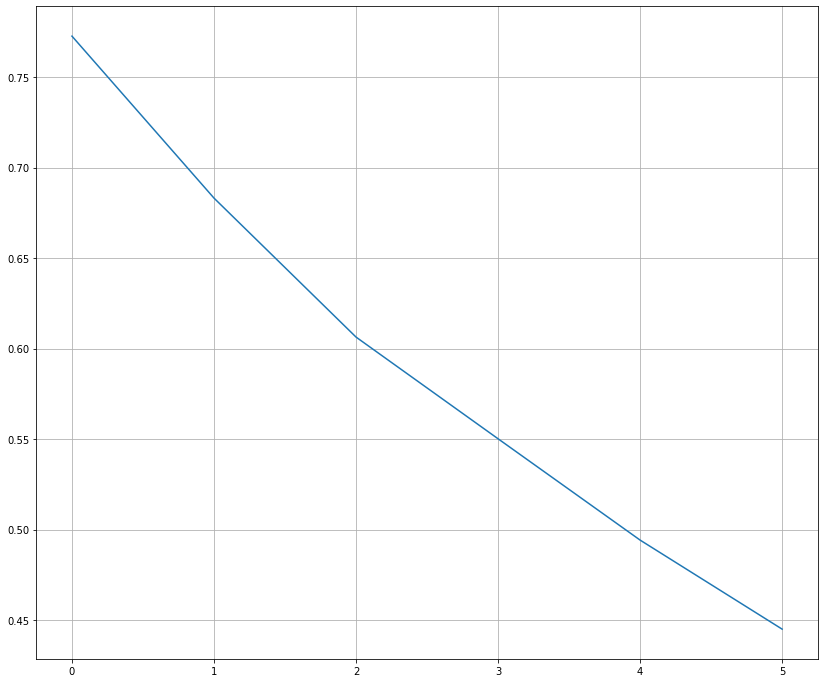

In [30]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), losses)
plt.grid()

In [31]:
losses = list()
preds = list()
acc_list = list()
# это переводит модель в режим предсказания
# то есть фиксируются статистики батч норма, дропаут не выкидывает фичи
# model.eval()

# заметьте, что мы поменяли наш лоадер на валидационный
losses = []

for i in range(epochs):
  count = 0
  for x, y in valid_loader:
      
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          # if count == 3:
          #   print(y_pred.argmax())
          #   print(y)
          # count += 1

          #loss = criterion(y_pred, y)
          ## (batch_size, n_classes) -> (batch_size, n_classes)
          # x = torch.softmax(x, dim=-1)
          

          optimizer.zero_grad()
          # loss.backward()
          optimizer.step()
          losses.append(loss)
  print(f"epoch {i}, loss {loss}")
          optimizer.zero_grad()
          # loss.backward()
          optimizer.step()
          losses.append(loss)
  print(f"epoch {i}, loss {loss}")

epoch 0, loss 0.4449681043624878
epoch 1, loss 0.4449681043624878
epoch 2, loss 0.4449681043624878
epoch 3, loss 0.4449681043624878
epoch 4, loss 0.4449681043624878
epoch 5, loss 0.4449681043624878


In [32]:
 preds[:3]

[]

In [33]:
losses = list()

# это переводит модель в режим предсказания
# то есть фиксируются статистики батч норма, дропаут не выкидывает фичи
model.eval()

# заметьте, что мы поменяли наш лоадер на валидационный
for x, y in valid_loader:
    
    with torch.no_grad():
        # получение предсказаний модели
        # расчет лосса
          y_pred = model.forward(x)
          loss = criterion(y_pred, y)
          losses.append(loss)
    

### **CNN**

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


In [35]:
class CNN(nn.Module):
	def __init__(self, batch_size, output_size, in_channels, out_channels, kernel_heights, stride, padding, keep_probab, vocab_size, 
              embedding_length, weights):
		super(CNN, self).__init__()
		
		"""
		Arguments
		---------
		batch_size : Size of each batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		in_channels : Number of input channels. Here it is 1 as the input data has dimension = (batch_size, num_seq, embedding_length)
		out_channels : Number of output channels after convolution operation performed on the input matrix
		kernel_heights : A list consisting of 3 different kernel_heights. Convolution will be performed 3 times and finally results 
    from each kernel_height will be concatenated.
		keep_probab : Probability of retaining an activation node during dropout operation
		vocab_size : Size of the vocabulary containing unique words
		embedding_length : Embedding dimension of GloVe word embeddings
		weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table
		--------
		
		"""
    self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])


		# self.batch_size = batch_size
		self.output_size = output_size
		self.in_channels = in_channels
		self.out_channels = out_channels
		self.kernel_heights = kernel_heights
		self.stride = stride
		self.padding = padding
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
		self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False)
		self.conv1 = nn.Conv2d(in_channels, out_channels, (kernel_heights[0], embedding_length), stride, padding)
		self.conv2 = nn.Conv2d(in_channels, out_channels, (kernel_heights[1], embedding_length), stride, padding)
		self.conv3 = nn.Conv2d(in_channels, out_channels, (kernel_heights[2], embedding_length), stride, padding)
		self.dropout = nn.Dropout(keep_probab)
		self.label = nn.Linear(len(kernel_heights)*out_channels, output_size)

IndentationError: ignored

In [ ]:
model = DeepCnnNetwork(embeddings=embeddings,
                           size_1=256, 
                           size_2=128, 
                           n_classes=len(category2index))

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

epochs = 3
losses = []
for i in range(epochs):
  for x, y in train_loader:
    y_pred = model.forward(x)
    loss = criterion(y_pred, y)
    
     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss)
  print(f"epoch {i}, loss {loss}")

In [53]:
class MyCNN(nn.Module):

  def __init__(self, embeddings, c1_in, c2_in, c2_out, n_classes):

    super().__init__()

    self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])

    self.conv1 = nn.Conv2d(in_channels=c1_in, out_channels=c2_in, 3, 1)
    self.conv2 = nn.Conv2d(in_channels==c2_in, out_channels=c2_out, 3, 1)
nn.Conv2d()
    # self.linear_1 = nn.Linear(in_features=embeddings.shape[-1], out_features=linear_1_size)
    # self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
    # self.linear_3 = nn.Linear(in_features=linear_2_size, out_features=n_classes)


  def forward(self, X):

    x = torch.relu(self.conv1(self.c1_in, batch_size, X))
    print(x.shape())
    x = torch.max_pool2d(X, 2, 2)
    print(x.shape())
    x = torch.relu(self.conv2(self.c2_in, batch_size, X))
    print(x.shape())
    x = torch.max_pool2d(X, 2, 2)
    print(x.shape())

    x = self.linear_1(x)
    print(x.shape())
       
    x = torch.relu(x)
    print(x.shape())

    # # прогоняем через второй линейный слой
    # # (batch_size, linear_1_size) -> (batch_size, linear_2_size)
    # x = self.linear_2(x)
    # print(x.shape())

    # # применяем нелинейность
    # # (batch_size, linear_2_size) -> (batch_size, linear_2_size)
    # x = torch.relu(x)
    # print(x.shape())

    # # переводим с помощью линейного преобразования в количество классов
    # # (batch_size, linear_2_size) -> (batch_size, n_classes)
    # x = self.linear_3(x)
    # print(x.shape())
 


    return x


IndentationError: ignored

In [48]:
#1, 6, 12
128/2


64.0

In [51]:
model = MyCNN(embeddings=embeddings,
                           c1_in=1,
                           c2_in=6, 
                           c2_out=18, 
                           n_classes=len(category2index))

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

epochs = 3
losses = []
for i in range(epochs):
  for x, y in train_loader:
    y_pred = model.forward(x)
    loss = criterion(y_pred, y)
    
     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss)
  print(f"epoch {i}, loss {loss}")

RuntimeError: ignored